In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [1]:
import pandas as pd
df1 = pd.read_csv('Dataset_2020.csv',
                                      parse_dates=['TIME'],
                                      index_col=['TIME'],
                                      )
df2 = pd.read_csv('Dataset_2021.csv',
                                      parse_dates=['TIME'],
                                      index_col=['TIME'],
                                      )
df = pd.concat([df1, df2])
df.sort_values(by = ['TIME'], inplace = True)

C:\Users\kawba\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
df3 = df.drop(['NUMBER', 'GENERAL_AREA', 'SPECIFIC_AREA', 'FAILING', 'YEAR',
       'MONTH', 'DAY_OF_WEEK', 'HOUR', 'X', 'Y', '(X, Y)'], axis = 1)

In [3]:
data1 = df3.loc[(df['CODE'] == 1402)]
data2 = df3.loc[(df['CODE'] == 3301)]

In [5]:
data2

,CODE
TIME,
2020-01-01 02:07:00,3301
2020-01-01 02:19:00,3301
2020-01-01 02:59:00,3301
2020-01-01 03:22:00,3301
2020-01-01 03:29:00,3301
...,...
2021-07-07 06:42:00,3301
2021-07-07 16:15:00,3301
2021-07-07 17:38:00,3301


In [6]:
dfdaily_4402 =data1.resample('D').count()
dfdaily_3301 =data2.resample('D').count()

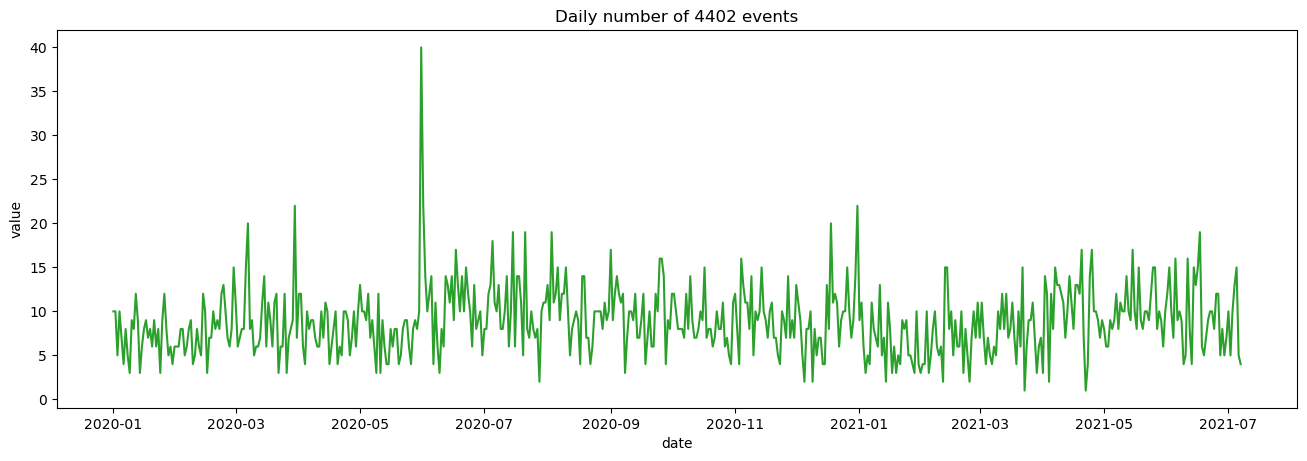

In [8]:
def plot_df(df, x, y, title ='', xlabel = 'date', ylabel = 'value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:green')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_df(dfdaily_4402, x = dfdaily_4402.index, y =dfdaily_4402['CODE'], title ='Daily number of 4402 events')

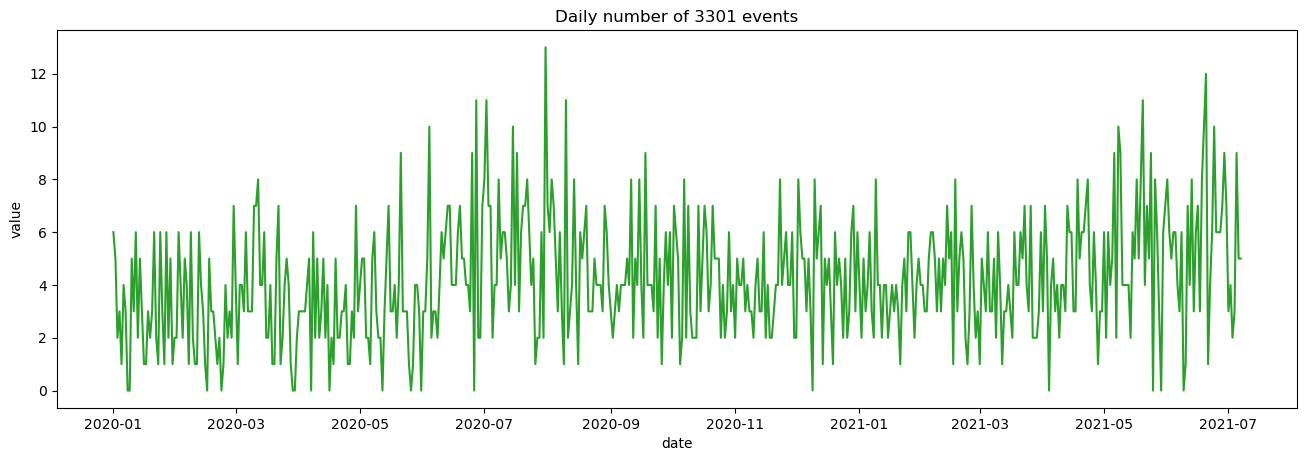

In [9]:
plot_df(dfdaily_3301, x = dfdaily_3301.index, y =dfdaily_3301['CODE'], title ='Daily number of 3301 events')

Decompose the Data

The next step is to decompose the data to view more of the complexity behind the linear visualization. 

In [10]:
y1 = dfdaily_4402['CODE']
y2 = dfdaily_3301['CODE']
import statsmodels.api as sm
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

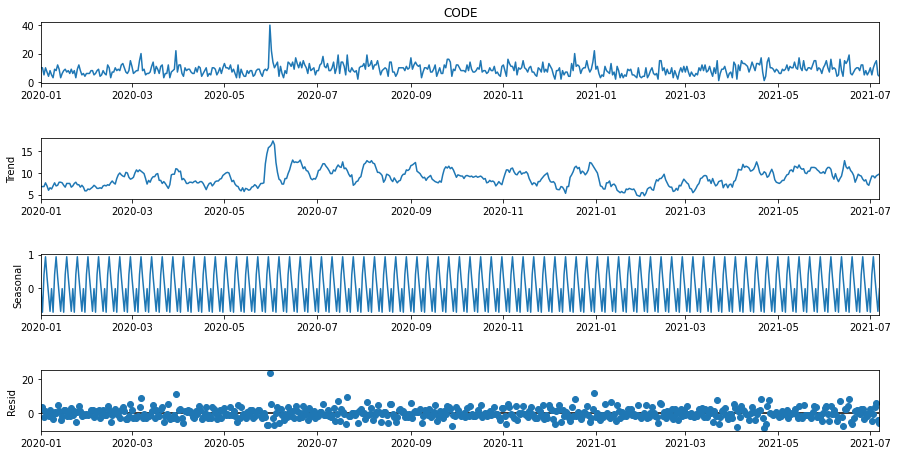

In [11]:
seasonal_decompose(y1)

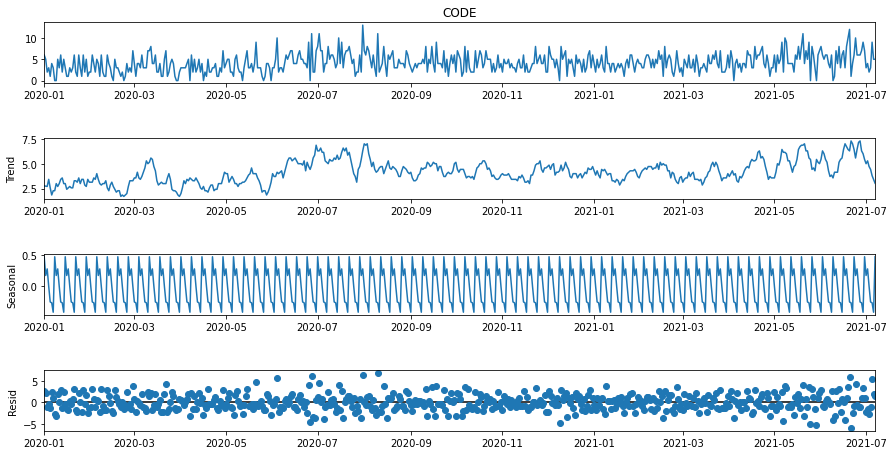

In [12]:
seasonal_decompose(y2)

In [13]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

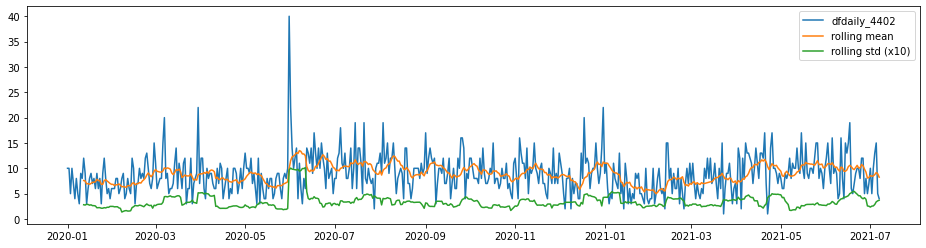

In [14]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y1,'dfdaily_4402')

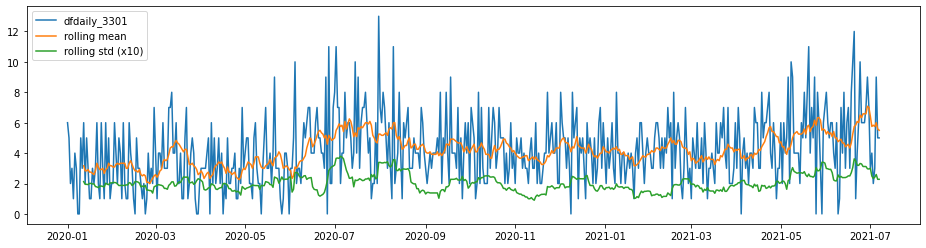

In [15]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y2,'dfdaily_3301')

In [16]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
ADF_test(y1,'dfdaily_4402')

 > Is the dfdaily_4402 stationary ?
Test statistic = -8.447
P-value = 0.000
Critical values :
	1%: -3.4423174665535385 - The data is  stationary with 99% confidence
	5%: -2.866818952732754 - The data is  stationary with 95% confidence
	10%: -2.569581505602171 - The data is  stationary with 90% confidence


In [17]:
ADF_test(y2,'dfdaily_3301')

 > Is the dfdaily_3301 stationary ?
Test statistic = -3.053
P-value = 0.030
Critical values :
	1%: -3.4425405682241816 - The data is not stationary with 99% confidence
	5%: -2.8669171671779816 - The data is  stationary with 95% confidence
	10%: -2.5696338432333636 - The data is  stationary with 90% confidence


The data for both events are stationary. 

Now we can split the datasets to train and test, then model 

In [18]:
len(y1)*.7

387.79999999999995

In [20]:
len(y2)*.7

387.79999999999995

In [21]:
dfdaily_4402.iloc[388]

CODE    8
Name: 2021-01-23 00:00:00, dtype: int64

In [22]:
dfdaily_3301.iloc[388]

CODE    5
Name: 2021-01-23 00:00:00, dtype: int64

In [23]:
y1_to_train = y1[:'2021-01-23'] # dataset to train
y1_to_val = y1['2021-01-24':] # last X months for test  
predict_date = len(y1) - len(y1[:'2021-01-24']) # the number of data points for the test set

In [24]:
y2_to_train = y2[:'2021-01-23'] # dataset to train
y2_to_val = y2['2021-01-24':] # last X months for test  
predict_date = len(y2) - len(y2[:'2021-01-24']) # the number of data points for the test set

We'll model with SARIMA which is suitable for time series data with trend and/or seasonal components

In [25]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))


In [26]:
sarima_grid_search(y1,60)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 60) - AIC:2454.664442340707


In [27]:
sarima_grid_search(y2,60)

C:\Users\kawba\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The set of parameters with the minimum AIC is: SARIMA(0, 1, 1)x(0, 1, 1, 60) - AIC:2000.3553079561757


In [28]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Occurrence')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

for Event 4402

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8515      0.068     12.460      0.000       0.718       0.985
ma.L1         -0.6981      0.091     -7.665      0.000      -0.877      -0.520
ma.S.L60      -1.0000   1119.162     -0.001      0.999   -2194.517    2192.517
sigma2        13.8256   1.55e+04      0.001      0.999   -3.03e+04    3.03e+04


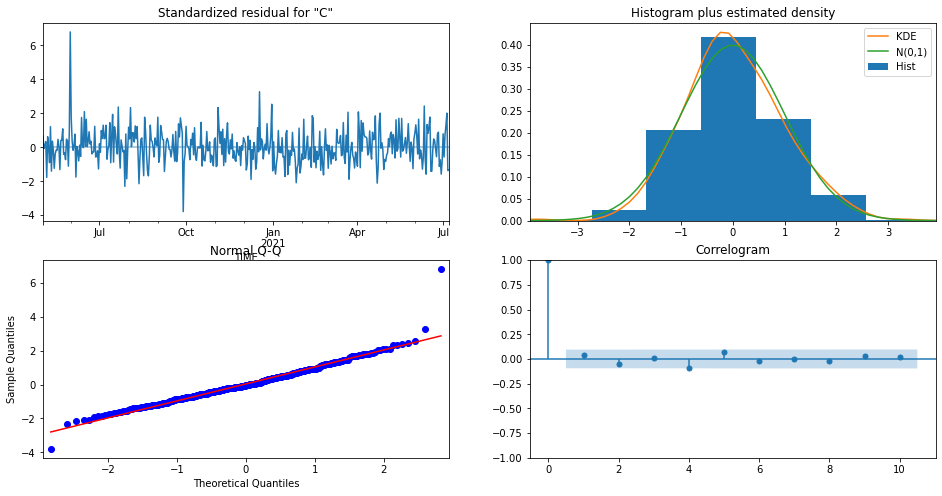

The Root Mean Squared Error of SARIMA with season_length=60 and dynamic = False 3.88


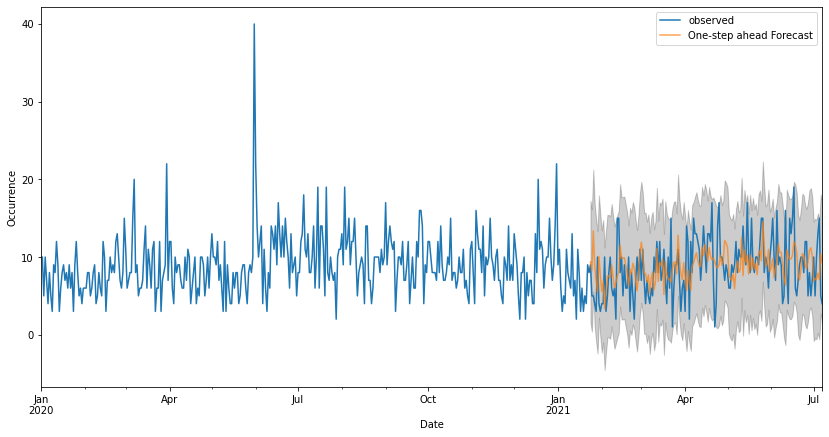

The Root Mean Squared Error of SARIMA with season_length=60 and dynamic = True 4.03


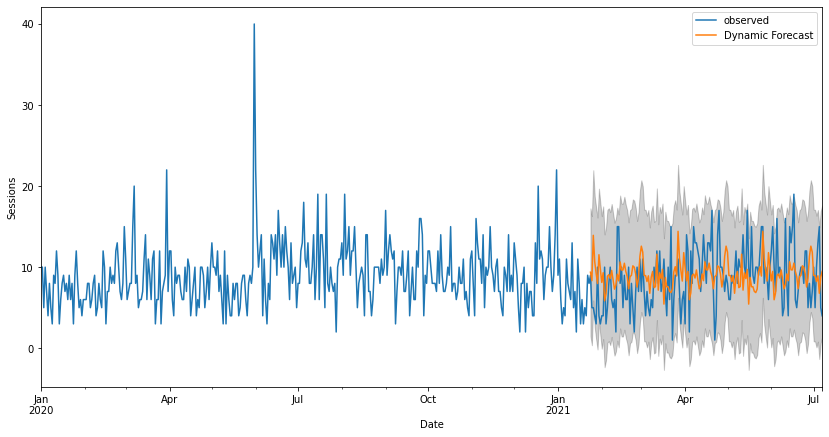

In [30]:
model1 = sarima_eva(y1,(1, 0, 1),(0, 1, 1, 60),60,'2021-01-24',y1_to_val)

For event 3301

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9884      0.011     89.217      0.000       0.967       1.010
ma.L1         -0.9405      0.024    -38.740      0.000      -0.988      -0.893
ma.S.L60      -0.7872      0.065    -12.095      0.000      -0.915      -0.660
sigma2         5.5700      0.425     13.108      0.000       4.737       6.403


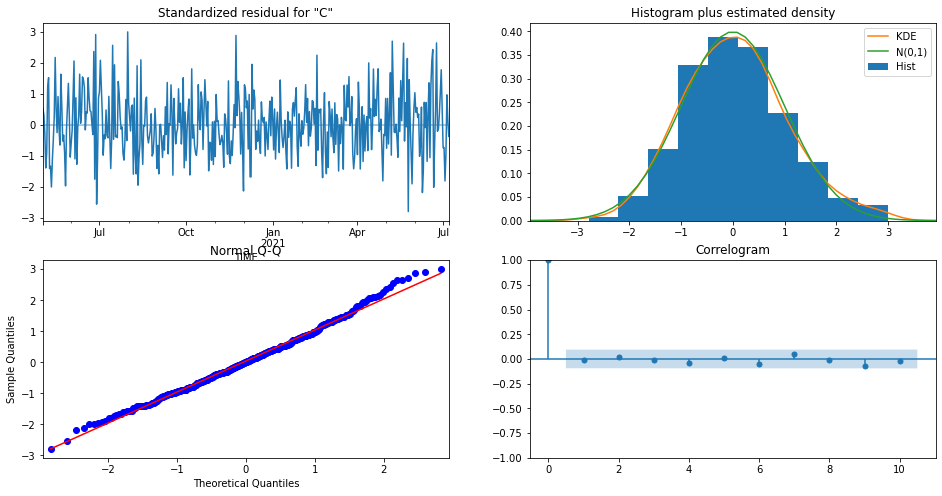

The Root Mean Squared Error of SARIMA with season_length=60 and dynamic = False 2.42


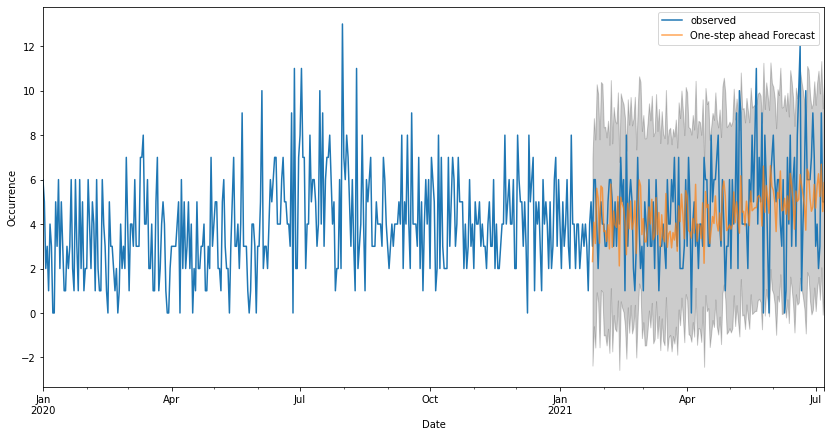

The Root Mean Squared Error of SARIMA with season_length=60 and dynamic = True 2.58


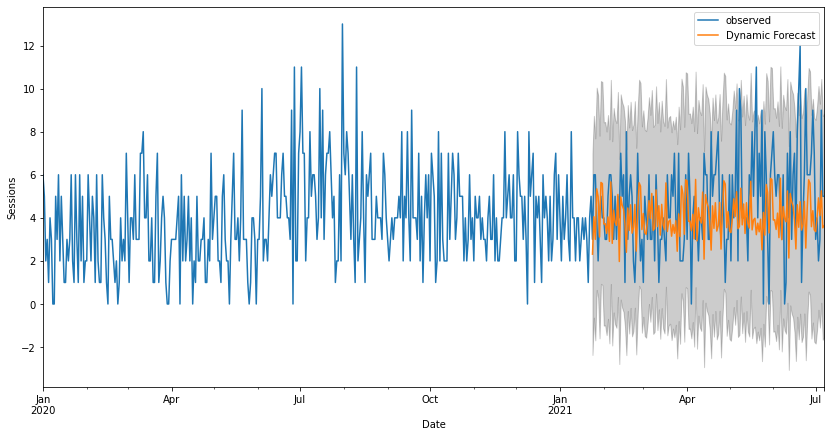

In [31]:
model2 = sarima_eva(y2,(1, 0, 1),(0, 1, 1, 60),60,'2021-01-24',y2_to_val)

Now lets' forcast for the next 60 days

In [32]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

Forecast for 4402

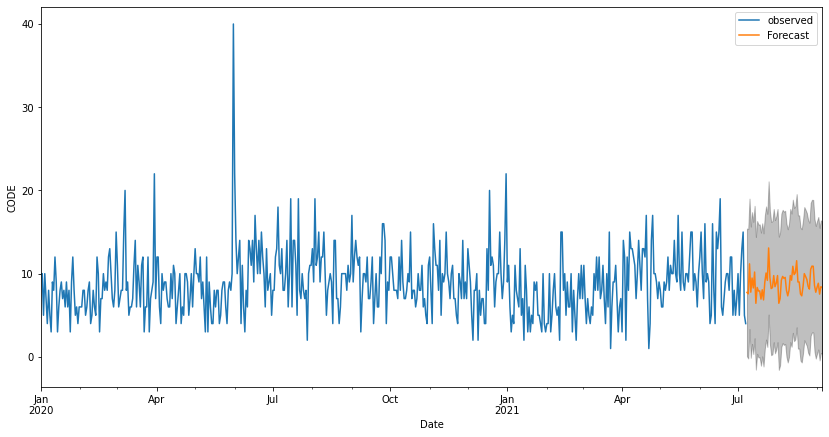

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2021-07-08,7.74413902,0.06216990,15.42610813
1,2021-07-09,7.57641077,-0.19540969,15.34823123
2,2021-07-10,11.17836453,3.34204066,19.01468841
3,2021-07-11,7.77343450,-0.10932819,15.65619718
4,2021-07-12,9.47374319,1.55747990,17.39000647


In [33]:
final_table1 = forecast(model1,60,y1)
final_table1.head()

Forecast for event 3301

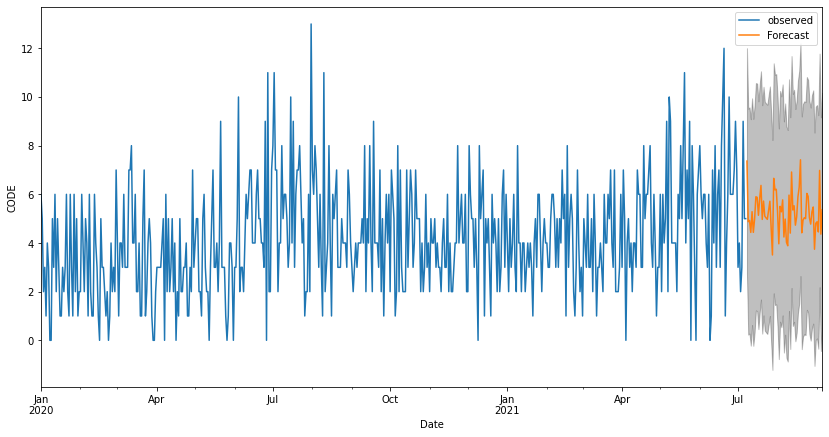

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2021-07-08,7.36614834,2.72829371,12.00400297
1,2021-07-09,4.87584473,0.23268779,9.51900168
2,2021-07-10,4.92619886,0.27786787,9.57452984
3,2021-07-11,4.43412450,-0.21925549,9.08750450
4,2021-07-12,5.28684696,0.62853983,9.94515410


In [34]:
final_table2 = forecast(model2,60,y2)
final_table2.head()